In [43]:
from bayes_opt import BayesianOptimization
from LC_opt_defs import Spec
import math

In [20]:
starts = [0.1, 100, 10000]
ends = [7, 1000, 1000000]
limits = [0.1, 0.7, 0.3]
directions = ["stop", "pass", "stop"]
spec = Spec(starts, ends, limits, directions, margin=0.47, n=1000)

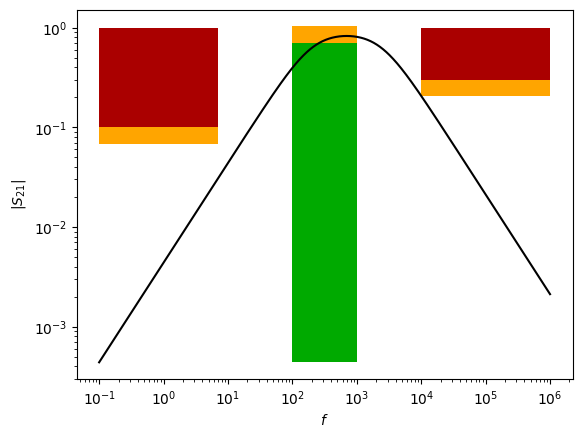

-0.08039616428633192

In [21]:
spec.cost(plot=True, par1C=math.log(3e-6), ser1C=math.log(7e-6))

In [22]:
pbounds = {'par1C': (math.log(1e-7), math.log(1e-2)), 'ser1C': (math.log(1e-7), math.log(1e-2))}

optimizer = BayesianOptimization(
    f=spec.cost,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=4,
    n_iter=10,
)

print(optimizer.max)

|   iter    |  target   |   par1C   |   ser1C   |
-------------------------------------------------
| 1         | -0.4792   | -11.32    | -7.825    |
| 2         | -0.4844   | -16.12    | -12.64    |
| 3         | -0.6785   | -14.43    | -15.06    |
| 4         | -0.1549   | -13.97    | -12.14    |
| 5         | -0.2314   | -14.87    | -11.87    |
| 6         | -0.04834  | -13.54    | -10.76    |
| 7         | -0.1832   | -11.02    | -11.86    |
| 8         | -1.597    | -5.537    | -13.95    |
| 9         | -1.325    | -16.12    | -4.605    |
| 10        | -1.938    | -4.605    | -4.605    |
| 11        | -0.04505  | -12.07    | -10.52    |
| 12        | -0.04307  | -12.59    | -11.27    |
| 13        | -0.059    | -12.92    | -10.03    |
| 14        | -0.0259   | -12.81    | -10.73    |
{'target': -0.02589939786005873, 'params': {'par1C': -12.805451611658807, 'ser1C': -10.726619785041901}}


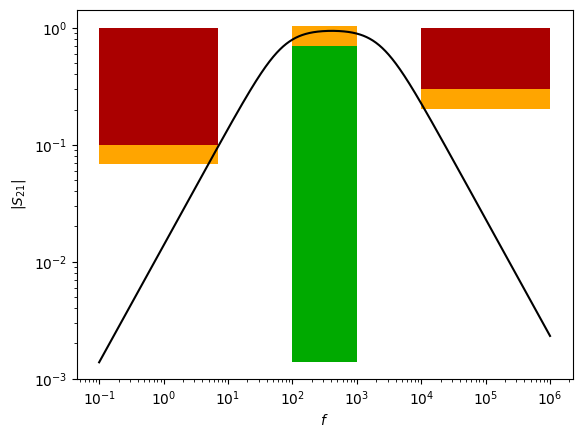

-0.02589939786005873

In [23]:
spec.cost(plot=True, par1C=optimizer.max['params']['par1C'], ser1C=optimizer.max['params']['ser1C'])

In [44]:
import math
math.log(1+1)

0.6931471805599453

In [111]:
# 4 bands: stop-pass-stop-pass
# 1Hz - 10kHz, 20KHz - 14MHz, 26MHz - 100MHz, 200MHz - 1GHz

starts = [1, 2e4, 20e6, 200e6]
ends = [7e3, 12e6, 100e6, 1e9]
limits = [0.1, 0.7, 0.05, 0.1]
directions = ["stop", "pass", "stop", "pass"]
spec = Spec(starts, ends, limits, directions, margin=0.47, n=1000)

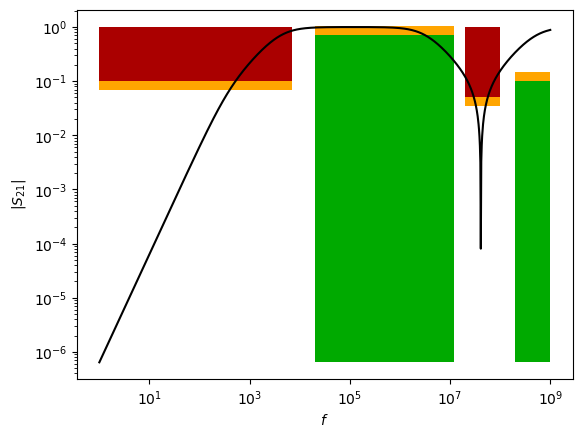

-0.3634585542863684

In [112]:
spec.cost(plot=True, par1L = math.log(9e-4), ser1C = math.log(9e-6), ser2L = math.log(5e-6), ser2C = math.log(3e-12))

In [113]:
pbounds = {'par1L': (math.log(1e-6), math.log(6e-3)), 'ser1C': (math.log(1e-9), math.log(9e-3)), 'ser2L': (math.log(1e-7), math.log(1e-4)), 'ser2C': (math.log(1e-15),math.log(1e-9))}

optimizer = BayesianOptimization(
    f=spec.cost,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=4,
    n_iter=10,
)

print(optimizer.max)

|   iter    |  target   |   par1L   |   ser1C   |   ser2C   |   ser2L   |
-------------------------------------------------------------------------
| 1         | -0.4217   | -10.19    | -9.189    | -34.54    | -14.03    |
| 2         | -1.16     | -12.54    | -19.24    | -31.97    | -13.73    |
| 3         | -0.3323   | -10.36    | -12.1     | -28.75    | -11.38    |
| 4         | -0.8919   | -12.04    | -6.662    | -34.16    | -11.49    |
| 5         | -0.2488   | -9.99     | -12.31    | -28.35    | -11.66    |
| 6         | -0.4674   | -7.767    | -11.42    | -28.75    | -13.98    |
| 7         | -0.4671   | -9.125    | -12.78    | -25.27    | -11.03    |
| 8         | -0.4391   | -11.33    | -12.84    | -27.0     | -14.04    |
| 9         | -0.3351   | -7.857    | -14.38    | -28.84    | -10.97    |
| 10        | -0.8308   | -6.711    | -10.97    | -28.46    | -9.283    |
| 11        | -0.2979   | -10.5     | -15.02    | -27.65    | -11.37    |
| 12        | -0.2008   | -7.563    | 

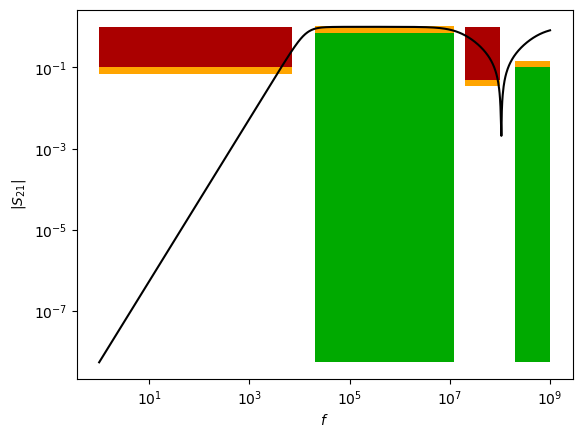

-0.20076899992816713

In [114]:
spec.cost(plot=True, par1L=optimizer.max['params']['par1L'], ser1C=optimizer.max['params']['ser1C'], ser2C=optimizer.max['params']['ser2C'], ser2L=optimizer.max['params']['ser2L'])

In [89]:
# lowpass filter pas-stop
# 0.1 - 200kHz, 400kHz - 10MHz

starts = [0.1, 400e3]
ends = [100e3, 10e6]
limits = [0.2, 0.4]
directions = ["pass", "stop"]
spec = Spec(starts, ends, limits, directions, margin=0.47, n=1000)

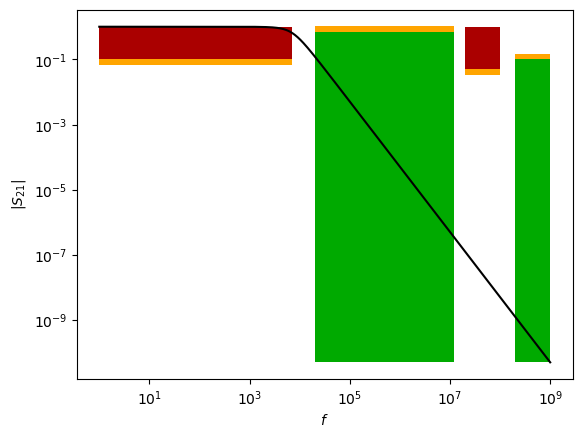

-5.978645365282217

In [110]:
spec.cost(plot=True, par1C = math.log(1e-6), ser1L = math.log(1e-3))

In [97]:
pbounds = {'par1C': (math.log(1e-7), math.log(1e-4)), 'ser1L': (math.log(1e-4), math.log(1e-2))}

optimizer = BayesianOptimization(
    f=spec.cost,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=4,
    n_iter=10,
)

print(optimizer.max)

|   iter    |  target   |   par1C   |   ser1L   |
-------------------------------------------------
| 1         | -0.4732   | -13.24    | -5.893    |
| 2         | -0.01187  | -16.12    | -7.818    |
| 3         | -0.01647  | -15.1     | -8.785    |
| 4         | -0.08259  | -14.83    | -7.619    |
| 5         | -1.127    | -9.21     | -9.21     |
| 6         | -0.3111   | -16.12    | -4.605    |
| 7         | 0.0       | -16.12    | -9.21     |
| 8         | -0.002807 | -15.86    | -8.547    |
| 9         | -0.001006 | -15.54    | -9.21     |
| 10        | -6.531e-0 | -16.12    | -8.719    |
| 11        | -4.453e-0 | -15.85    | -9.017    |
| 12        | 0.0       | -15.87    | -9.21     |
| 13        | 0.0       | -16.12    | -8.972    |
| 14        | -0.001029 | -16.12    | -8.456    |
{'target': 0.0, 'params': {'par1C': -16.11809565095832, 'ser1L': -9.210340371976182}}


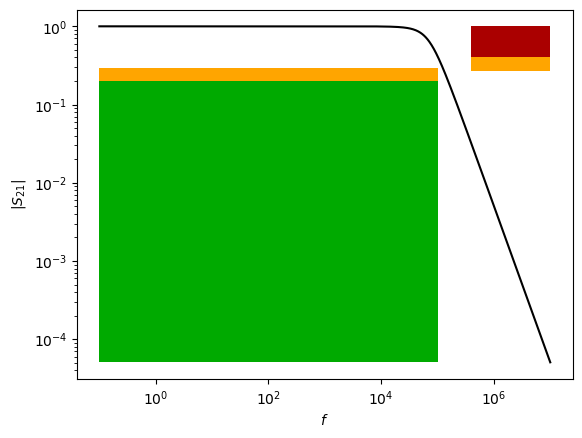

0.0

In [100]:
spec.cost(plot=True, par1C=optimizer.max['params']['par1C'], ser1L=optimizer.max['params']['ser1L'])